## Natural Language Processsing ile IMDB Film Yorumları Kaggle Veri Seti Üzerinden Sentiment(Duygu Analizi) Projesi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from bs4 import BeautifulSoup
import re
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords


In [2]:
df = pd.read_csv('NLPlabeledData.tsv', delimiter='\t', quoting=3) # tab ile ayrıldığı için \t, quoting: gereksiz noktalama aişaretlerinden kurtulmak için.

In [3]:
df

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...,...
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."


In [4]:
len(df['review'])

25000

In [5]:
# the, is, are gibi 'Stopwords' kelimeleri temizlemek için nltk kütüphanesinden stopwords kelime setini bilgisayarımıza indirmke lazım
# bunu nltk ile yapıyoruz

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FURKAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **** Veri Temizleme İşlemleri****

### Özellikle BeatufilSoup modülünü kullanarak HTML taglerini review cümlelerimizden sileceğiz 

 Önce örnek bir review seçilerek nasıl yapıldığına bakalım

In [6]:
sample_review = df.review[0]
sample_review

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [7]:
# HTML tagleri temizleme
sample_review = BeautifulSoup(sample_review).get_text()
sample_review

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 2

In [8]:
# Noktalama İşaretleri ve sayılardan temizliyoruz - regex kullanarak
# “^” metakarakterinin bir görevi: “Hariç” anlamına gelmek…  Bu görevini sadece “[]” metakarakterinin içinde kullanıldığı zaman yerine getirir.
# sub() = replace() öğeyi değiştirmeye yarar.
# noktalama işaretleri ve varsa sayılar kalkıcak

sample_review = re.sub("[^A-Za-z]",' ',sample_review)
sample_review

# A'dan Z'ye, a'dan z'ye harfler dışındaki herşeyi, ' '(boşluk) ile değiştir

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    m

In [9]:
# Küçük harfe dönüştürüyoruz. Makine Öğrenim algortimalarımız büyük harfle başlayan kelimleri farklı aşgılamasın diye:

sample_review = sample_review.lower()
sample_review

' with all this stuff going down at the moment with mj i ve started listening to his music  watching the odd documentary here and there  watched the wiz and watched moonwalker again  maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  some of it has subtle messages about mj s feeling towards the press and also the obvious message of drugs are bad m kay visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring  some may call mj an egotist for consenting to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really nice of him the actual feature film bit when it finally starts is only on for    m

In [10]:
#  stopwords(the,is,are) gibi kelimelerin yapay zeka tarafından kullnılmamasını isityoruz. Bunlar gramer kelimleri
#  bunun için stopwords metodunu kullanıcaz ama ayırmamız lazım çünkü bizden tek tek liste istiyor. split ile ayırarak başlayalım:

sample_review = sample_review.split()
sample_review

['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with',
 'mj',
 'i',
 've',
 'started',
 'listening',
 'to',
 'his',
 'music',
 'watching',
 'the',
 'odd',
 'documentary',
 'here',
 'and',
 'there',
 'watched',
 'the',
 'wiz',
 'and',
 'watched',
 'moonwalker',
 'again',
 'maybe',
 'i',
 'just',
 'want',
 'to',
 'get',
 'a',
 'certain',
 'insight',
 'into',
 'this',
 'guy',
 'who',
 'i',
 'thought',
 'was',
 'really',
 'cool',
 'in',
 'the',
 'eighties',
 'just',
 'to',
 'maybe',
 'make',
 'up',
 'my',
 'mind',
 'whether',
 'he',
 'is',
 'guilty',
 'or',
 'innocent',
 'moonwalker',
 'is',
 'part',
 'biography',
 'part',
 'feature',
 'film',
 'which',
 'i',
 'remember',
 'going',
 'to',
 'see',
 'at',
 'the',
 'cinema',
 'when',
 'it',
 'was',
 'originally',
 'released',
 'some',
 'of',
 'it',
 'has',
 'subtle',
 'messages',
 'about',
 'mj',
 's',
 'feeling',
 'towards',
 'the',
 'press',
 'and',
 'also',
 'the',
 'obvious',
 'message',
 'of',
 'drugs',

In [11]:
len(sample_review)

437

In [12]:
# simplw_review without stopwords

swords = set(stopwords.words('english'))      # conversion into set for fast searching, ing stopwords kelimelerini atadık

sample_review = [w for w in sample_review if w not in swords] # sample_review'daki tüm kelimelerden swords'de olmayanları al
sample_review                                                 # stopwords'ün içinde değilse o kelime onu sample_review'e al

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary',
 'watched',
 'wiz',
 'watched',
 'moonwalker',
 'maybe',
 'want',
 'get',
 'certain',
 'insight',
 'guy',
 'thought',
 'really',
 'cool',
 'eighties',
 'maybe',
 'make',
 'mind',
 'whether',
 'guilty',
 'innocent',
 'moonwalker',
 'part',
 'biography',
 'part',
 'feature',
 'film',
 'remember',
 'going',
 'see',
 'cinema',
 'originally',
 'released',
 'subtle',
 'messages',
 'mj',
 'feeling',
 'towards',
 'press',
 'also',
 'obvious',
 'message',
 'drugs',
 'bad',
 'kay',
 'visually',
 'impressive',
 'course',
 'michael',
 'jackson',
 'unless',
 'remotely',
 'like',
 'mj',
 'anyway',
 'going',
 'hate',
 'find',
 'boring',
 'may',
 'call',
 'mj',
 'egotist',
 'consenting',
 'making',
 'movie',
 'mj',
 'fans',
 'would',
 'say',
 'made',
 'fans',
 'true',
 'really',
 'nice',
 'actual',
 'feature',
 'film',
 'bit',
 'finally',
 'starts',
 'minutes',
 'excluding',
 'smooth',
 'crim

In [13]:
len(sample_review)


219

In [14]:
# Tüm reviweleri döngü içinde temizlemek için fonksiyon oluşturalım

In [15]:
def process(review):
    #review without HTML Tags
    review = BeautifulSoup(review).get_text()
    # review without puncutation and number
    review = re.sub("[^A-Za-z]",' ',review)
    # converting info lowercase and splitting to eleminate stopwords
    review = review.lower()
    review = review.split()
    # review without stopwords
    swords = set(stopwords.words('english'))
    review = [w for w in review if w not in swords]
    # splitted paragrafları space ile birleştirelim
    return(" ".join(review))

In [16]:
# training datamızı yukarıdaki fonksiyon yardımıyla temizliyoruz
# her 1000 review sonrası 1 satır yazdırarak review işleminin durumunu görüyoruz.77

train_x_tum = []

for r in range(len(df['review'])):
    if (r+1)%1000==0:
        print("yazılmış inceleme sayısı:", r+1)
      
    train_x_tum.append(process(df['review'][r]))



C:\Users\FURKAN\AppData\Local\Temp\ipykernel_23072\1059406248.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review).get_text()


yazılmış inceleme sayısı: 1000
yazılmış inceleme sayısı: 2000
yazılmış inceleme sayısı: 3000
yazılmış inceleme sayısı: 4000
yazılmış inceleme sayısı: 5000
yazılmış inceleme sayısı: 6000
yazılmış inceleme sayısı: 7000
yazılmış inceleme sayısı: 8000
yazılmış inceleme sayısı: 9000
yazılmış inceleme sayısı: 10000
yazılmış inceleme sayısı: 11000
yazılmış inceleme sayısı: 12000
yazılmış inceleme sayısı: 13000
yazılmış inceleme sayısı: 14000
yazılmış inceleme sayısı: 15000
yazılmış inceleme sayısı: 16000
yazılmış inceleme sayısı: 17000
yazılmış inceleme sayısı: 18000
yazılmış inceleme sayısı: 19000
yazılmış inceleme sayısı: 20000
yazılmış inceleme sayısı: 21000
yazılmış inceleme sayısı: 22000
yazılmış inceleme sayısı: 23000
yazılmış inceleme sayısı: 24000
yazılmış inceleme sayısı: 25000


#### Train, test, split

In [37]:
x = train_x_tum
y = np.array(df["sentiment"])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.1, random_state=42)

#### Bag of Words oluşturuyoruz.

Yapay zekanın çalışması için bu metin tabanlı verilerin sayılara ve bag of words denilen matrise dönüştürmek gerekiyor
Bu amaçla sklearn içinde bulunan CountVectorizer aracını kullanıyoruz.




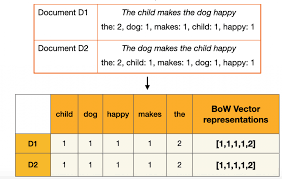

In [38]:
from IPython.display import Image
Image("indir.png")

In [39]:
# sklearn içindeki CountVectorizer fonksiyonu kullanılarak max 5000 kelimelik bag of wards oluşturuyoruz

vectorizer = CountVectorizer(max_features=5000)

# train verilerimizi feature vector matrisine çevirelim

x_train = vectorizer.fit_transform(x_train)

In [40]:
x_train

<22500x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1776690 stored elements in Compressed Sparse Row format>

In [41]:
# Bunu array'e dönüştürüyoruz çünkü fit işlemi için array istiyor..

x_train = x_train.toarray()

In [42]:
x_train.shape, y_train.shape

((22500, 5000), (22500,))

In [43]:
y_train

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

### Random Forest modeli oluşturuyoruz ve fit ediyoruz

In [44]:
model = RandomForestClassifier(n_estimators=100, random_state=42) # 100 tane karar ağacı kullanalım
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

### Şimdi sıra test datamızda.

In [46]:
# Test verilerimizi feature vektöre matrisine çeviriyoruz
# Yani aynı işlemleri(bag of wordse dönüştürme) tekrarlıyoruz bu sefer test datamız için:
test_xx = vectorizer.transform(x_test)
test_xx

<2500x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 198330 stored elements in Compressed Sparse Row format>

In [48]:
test_xx = test_xx.toarray()

### Prediction 

In [51]:
test_predict = model.predict(test_xx)
dogruluk = roc_auc_score(y_test,test_predict)

print("Doğruluk Yüzdemiz: % ",dogruluk * 100)

Doğruluk Yüzdemiz: %  84.12705119537827
